In [10]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from src.CPQAOA import CP_QAOA
from src.Grid import Grid
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo,
                       qubo_cost,
                       partitioned_averages)

In [2]:
# Number of Qubits 
N=6
# number of excitations
k=3
# RNG seed for reproducibility
seed=4
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Nr. of layer repetitions
layers=1
# Maximal number of iterations for classical solver
max_iter=400
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = True


my_chain = Chain(N_qubits=N)
print(f' Qubit indices in chain: \n', my_chain.get_chain_indexing())
print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_chain.get_NN_indices())
print(f'\n Corresponding Nearest Neighbor + Next Nearest index pairs: \n', my_chain.get_NNN_indices())
init_strat = np.array([0,1,0,1,0,1])
my_chain.set_initialization_strategy(strategy=init_strat)
print(f'\n Initialization strategy is: \n', my_chain.get_initialization_strategy())
print(f'\n Corresponding indices is: \n', my_chain.get_initialization_indices())

# Deciding between grid and 1d chain topology
my_topology = my_chain

 Qubit indices in chain: 
 [0 1 2 3 4 5]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]

 Corresponding Nearest Neighbor + Next Nearest index pairs: 
 [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5)]

 Initialization strategy is: 
 [0 1 0 1 0 1]

 Corresponding indices is: 
 [1, 3, 5]


In [3]:
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states for original portfolio problem
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
full_space_max_cost = full_result['c_max']
portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
print(f"Min. cost portfolio (constrained subspace): {portfolio_subspace_min_cost}")
print("Optimal portfolio state (constrained subspace) is: |"+portfolio_subspace_min_state_str+">")

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances, 
                     alpha=alpha,
                     lmbda=lmbda+1e-8, # Adding small constant purposely
                     k=k)
QUBO_limits = qubo_limits(Q=Q,offset=offset)
qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
print(f"Min. cost QUBO: {qubo_min_cost}")
print("Min. cost QUBO state is: |"+qubo_min_state_str+">")
print("Check that qubo min cost is same as portfolio min cost:")
print(qubo_min_cost, portfolio_subspace_min_cost)
print("Check that qubo max cost is at least portfolio max cost:")
print(qubo_max_cost, portfolio_subspace_max_cost)

# Generating instances of ansatz'
CP_z_phase_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 topology=my_topology,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_gradient=True,
                 with_z_phase=False)

Min. cost portfolio (constrained subspace): 2.724253296126501
Optimal portfolio state (constrained subspace) is: |100110>
Min. cost QUBO: 2.724253296126502
Min. cost QUBO state is: |100110>
Check that qubo min cost is same as portfolio min cost:
2.724253296126502 2.724253296126501
Check that qubo max cost is at least portfolio max cost:
48.32754728628957 7.819304086343843


In [4]:
# Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead', 'BFGS']
optimizer_method = available_methods[0]

# Generating callback function for plotting
CP_z_phase_costs = [] # Normalized costs
CP_z_phase_probs = [] # probability of optimal state
CP_z_phase_most_probables = []
solver_costs=[]

def CP_z_phase_callback_function(x):
    _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
    CP_z_phase_most_probables.append(list(_dict_.keys())[np.argmax(list(_dict_.values()))])
    # N.B. Normalizing w. respect to full space max cost
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=portfolio_subspace_max_cost, 
                             min_cost=qubo_min_cost)
    if portfolio_subspace_min_state_str in list(_dict_.keys()):
        CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
    else:
        CP_z_phase_probs.append(0)
    CP_z_phase_costs.append(_cost_)
    

# Generating initial guess for rotation angles for CP_ansatz
np.random.seed(seed)
theta_min, theta_max = -2*np.pi, 2*np.pi
N_angles = layers * len(my_topology.get_NN_indices())
if w_next_nearest_neighbors:
    N_angles = layers * len(my_topology.get_NNN_indices())
CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
print(f"CP+Z-PHASE: {len(CP_z_phase_theta_i)}")    

CP+Z-PHASE: 9


In [5]:
CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, 
                                      x0=CP_z_phase_theta_i,
                                      method='BFGS',
                                      options={'disp': False, 
                                               'gtol':1e-8,
                                               'eps':1.5e-8,
                                               'maxiter': max_iter},
                                      callback=CP_z_phase_callback_function)
CP_z_phase_res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -3.311707175388984
        x: [ 5.890e+00  7.854e-01  5.955e+00  2.356e+00  2.749e+00
            -3.142e+00  5.917e+00 -6.283e+00 -3.142e+00]
      nit: 19
      jac: [-2.961e-08  2.368e-07  0.000e+00  8.882e-08  2.072e-07
             8.882e-07  0.000e+00 -3.257e-07 -5.921e-08]
 hess_inv: [[ 4.239e-01 -1.944e-01 ... -9.009e-02 -2.593e-02]
            [-1.944e-01  2.191e-01 ...  1.249e-01  1.156e-01]
            ...
            [-9.009e-02  1.249e-01 ...  5.506e-01 -8.658e-03]
            [-2.593e-02  1.156e-01 ... -8.658e-03  1.022e+00]]
     nfev: 970
     njev: 96

0.0 0.999999999999051


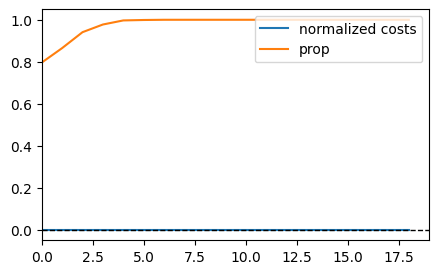

In [6]:
# N.B. Because the normalization is done w. respect to the "allowed states (w. k ones)" QAOA has cost above 1.
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot([it for it in range(len(CP_z_phase_costs))], CP_z_phase_costs, label='normalized costs')
ax.plot([it for it in range(len(CP_z_phase_probs))], CP_z_phase_probs, label='prop')

ax.set_xlim(0,len(CP_z_phase_costs))
ax.hlines(0,0,len(CP_z_phase_costs),lw=1,linestyles='dashed',colors='k')
ax.legend(loc='upper right')
print(CP_z_phase_costs[-1],CP_z_phase_probs[-1])
plt.show()

In [8]:
theta_opt = CP_z_phase_res.x
print(theta_opt)

[ 5.8904862   0.78539816  5.95467565  2.356195    2.74889367 -3.14159235
  5.91713916 -6.28318537 -3.14159272]


In [9]:
THETAS = list(theta_opt)
eps = 1e-4
counter = 1
facs = [float(i) for i in range(1,30)]
saved = []
for angle in THETAS:
    angle_is_pi = False
    for multiplicative_factor in facs:
        for divisor in facs:
            if np.abs(multiplicative_factor*np.pi/divisor-angle) <= eps and angle not in saved:
                print(f'theta_{counter}: {angle} is approx.: {int(multiplicative_factor)}*pi/{int(divisor)}')     
                counter += 1
                saved.append(angle)
                angle_is_pi = True
            elif np.abs(-multiplicative_factor*np.pi/divisor-angle) <= eps and angle not in saved:
                print(f'theta_{counter}: {angle} is approx.: -{int(multiplicative_factor)}*pi/{int(divisor)}')     
                counter += 1
                saved.append(angle)
                angle_is_pi = True
    if not angle_is_pi:
        counter +=1

theta_1: 5.890486199119115 is approx.: 15*pi/8
theta_2: 0.7853981608477217 is approx.: 1*pi/4
theta_4: 2.3561949972320155 is approx.: 3*pi/4
theta_5: 2.748893668941772 is approx.: 7*pi/8
theta_6: -3.1415923491367885 is approx.: -1*pi/1
theta_8: -6.283185374779236 is approx.: -2*pi/1
theta_9: -3.14159272074038 is approx.: -1*pi/1


In [50]:
# Generating instances of ansatz'
CP_test_ansatz= CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 topology=my_topology,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=True,
                 with_gradient=True,
                 with_z_phase=False)

In [51]:
print(theta_opt)

[ 5.49778712 -1.57079636  2.62445743 -3.14159262 -2.35619486  3.92699078
 -3.92699092 -0.48596359  4.71238868]


In [52]:
# populating things
_ = CP_test_ansatz.get_cost(angles=theta_opt)

In [53]:
np.linalg.norm(CP_test_ansatz.get_gradient(angles=theta_opt))

6.671853252990024e-06

In [54]:
print(CP_test_ansatz.get_gradient(angles=theta_opt))

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.65209033e-06  3.90132874e-13 -6.30070364e-28  5.50784242e-21
  5.13147243e-07]
